# Quickstart 

Run through the minimal example on- https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

<br>

Torch is kind enough to provide domain specific (organized by task within domain) datasets in the packages; 
- TorchText - https://pytorch.org/text/stable/datasets.html for- Text Classification, Language Modeling, Machine Translation, Sequence Tagging, Question/Answer & UnSupervised Learning
- TorchVision - https://pytorch.org/vision/stable/datasets.html for- Image Classification, Image Detection/Segmentation, Optical Flow, Image Pairs, Image Captioning & Video Classification 
- TorchAudio - https://pytorch.org/audio/stable/datasets.html does not specify the tasks involved but offers links to original dataset works for more info



In [1]:
# 0 - Imports

import torch
from torch import nn
from torch.utils.data import DataLoader     #wraps the "torch.utils.data.Dataset" in a nice iterable
from torchvision import datasets        #custom vision datasets
from torchvision.transforms import ToTensor

from torchsummary import summary     #TensorFlow like Model Summaries, non-essential but nice snapshots of architectures

In [2]:
# 1 - Download FashionMNIST DataSet

# Download Training Set (this is one of the pre-loaded datasets that Torch Provides)
training_data = datasets.FashionMNIST(
    root="data", #where to download
    train=True, #flag for train or test subset
    download=False, #will download from scratch if True
    transform=ToTensor(), #can specify a pipeline for transforming (also provides a `target_transform` for modifying labels)
)

# Download Test Data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
)

In [3]:
# 2 - Create DataLoaders from DataSets

BATCH_SIZE = 8 #size of batches for model -- a good heuristic for this is "smaller is better" since this controls the amount of data we see before a weight update 

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Print out Shapes of Data & Corresponding Labels by Looping over one iter of a `DataLoader`
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}") #this method of looping returns 32 instances of data with each instance being a grayscale image (tensor) of shape [1, 28, 28]
    print(f"Shape of y: {y.shape} {y.dtype}") #int representing the class label
    break

Shape of X [N, C, H, W]: torch.Size([8, 1, 28, 28])
Shape of y: torch.Size([8]) torch.int64


In [7]:
[i.shape for i in next(iter(test_loader))] #view items in a sample iter return of DataLoader

[torch.Size([8, 1, 28, 28]), torch.Size([8])]

In [14]:
# 3 - Create Model

# Determine `device` for Network Computation
device = "cuda" if torch.cuda.is_available() else "cpu" #nice flag for setting device (will always work even if GPU availability is shifty, ehm ehm Google Colab)
print(f"Will use {device} as `device`") #"cuda" if you are not poor



# Define a Model Architecture -- sub-class the base `nn.Module` (gives all nice functions like train, eval, __call__, parameters, etc.)
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__() #this is what does the inheriting of methods from `nn.Module` (see "https://www.educative.io/edpresso/what-is-super-in-python")
        self.flatten = nn.Flatten() #this flattens the dims of tensors into nice arrays (in this case convert 1x28x28 tensors to 784x1 arrays)
        self.linear_relu_stack = nn.Sequential( #sequential is a useful method for preventing having to write the details of the forward pass out in the forward pass function!
            nn.Linear(28*28, 512),  # same dim as input ('flatten' step turns our matrix into a nice 784 array)
            nn.ReLU(),              # activation function -- see https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity for full list
            nn.Linear(512, 256),    # hidden layer, these dims specify the "weight matricies" of the network (this is a 2-hidden layer net!)
            nn.Hardswish(),         # activation function, getting kinky!
            nn.Linear(256, 10)      # Output Layer, 10 classes to predict so we have 10 output neurons
        )

    def forward(self, x):
        x = self.flatten(x) #perform the flattening/reshaping of input tensor (reshape "on arrival" so to speak)
        logits = self.linear_relu_stack(x) #forward pass here is done w the use of "nn.Sequential" -- could have manually wrote out the process of doing matmuls + activations 
        return logits #also can be thought of as "class_probabilities"

model = BaseNet().to(device) #Instantiate the model and send to our device (cpu or gpu if 'cuda')
print(model)


# Alternate Summary (non-essential but nice to visualize)
summary(model, input_size=(1, 28, 28)) #`input_size` here refers to the shape of a SINGLE example in the dataset (batch_size not relevant for this arg!)


Will use cuda as `device`
BaseNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Hardswish()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
         Hardswish-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input 

The way a neural network "learns" is by establishing some notion of "Loss" and optimizing the network parameters so as to decrease this loss - this is typically accomplished through [backpropagation](https://machinelearningjourney.com/index.php/2019/11/22/backpropagation/) which uses our established error along with gradient descent and the Chain Rule to update individual weights for all of the layers in our network. 

The choice of these are both task and user dependent (task determines a subset of what is available, i.e. regression or classification types of problems, and user then needs to determine which to use, based on a heuristic/preference/performance]) -- torch offers a bunch of stuff out of the box and the lists of tools can be found at:

- Loss Functions- https://pytorch.org/docs/stable/nn.html#loss-functions 
- Optimization Algorithms- https://pytorch.org/docs/stable/optim.html



In [15]:
# 4 - Define Loss & Optimization Functions

loss_fn = nn.CrossEntropyLoss() #CrossEntropy is a good choice for Classification (maximize the probability of our class of interest)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) #good old SGD, but ADAM is kinda cool to -- 1e-3=0.001 (optimizer accesses our Model's parameters w the call here)


In [16]:
# 5 - Define Training & Testing Functions 


# Train (this is defined independent of the Model Class but could be added as a method of "BaseNet")
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() #set model to training mode (does not do `Dropout` regularization and does not update `BatchNorm` statistics- https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch#:~:text=train()%20tells%20your%20model,train%20(see%20source%20code).)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) #need send data to same place as Model (ideally GPU if not poor)

        # run a Forward Pass & Get Loss
        pred = model(X) #calls "model.forward()" under the hood?
        loss = loss_fn(pred, y) #computes the CrossEntropyLoss between our forward pass output and ground truth label

        # Backpropagation -- learning time
        optimizer.zero_grad() #zero out gradients per batch (prev batch gradient, i.e. first order derivative vector, gets wiped so we update this batch w this batch's gradient)
        loss.backward() #computes derivative of loss wrt each parameter that has "requires_grad=True" (trainable params), this gets accumulated into "x.grad" for later use
                        #(no clue which item ".grad" belongs to in above), see- https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944 for more info
        optimizer.step() #using the gradient above, update all trainable params in network with: learning_rate * x.grad

        # Print out info about training per 100 batches
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# Test (for running a pass over the test dataset w our trained model)
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) #for computing accuracy (proportion of correct label predictions)
    n_batches = len(dataloader) #for computing average loss across all batches
    model.eval() #not training so change flag (more consistent regularization behavior, regularization not implemented here but likely would implement elsewhere)
    test_loss, correct = 0, 0

    with torch.no_grad(): #`no_grad` flag here does not do backprop, faster
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) #need be hanging out in same bar, GPU plz
            pred = model(X) #run a forward pass on a test batch 
            test_loss += loss_fn(pred, y).item() #computing loss on whole test set (divide by n_batches in below)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() #num of correct label predictions (not logits but actual label!)
    # Update Params for Printing & Print out info per test batch
    test_loss /= n_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



In [17]:
# 6 - Conduct a Training Cycle

epochs = 3

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.281727  [    0/60000]
loss: 2.297622  [  800/60000]
loss: 2.280348  [ 1600/60000]
loss: 2.268169  [ 2400/60000]
loss: 2.269630  [ 3200/60000]
loss: 2.253232  [ 4000/60000]
loss: 2.250683  [ 4800/60000]
loss: 2.240191  [ 5600/60000]
loss: 2.236240  [ 6400/60000]
loss: 2.239422  [ 7200/60000]
loss: 2.211428  [ 8000/60000]
loss: 2.221255  [ 8800/60000]
loss: 2.193507  [ 9600/60000]
loss: 2.202338  [10400/60000]
loss: 2.170942  [11200/60000]
loss: 2.200978  [12000/60000]
loss: 2.221339  [12800/60000]
loss: 2.055644  [13600/60000]
loss: 2.093967  [14400/60000]
loss: 2.076351  [15200/60000]
loss: 2.091294  [16000/60000]
loss: 1.971858  [16800/60000]
loss: 2.073160  [17600/60000]
loss: 1.988268  [18400/60000]
loss: 2.065758  [19200/60000]
loss: 2.091163  [20000/60000]
loss: 1.964535  [20800/60000]
loss: 1.979779  [21600/60000]
loss: 2.003055  [22400/60000]
loss: 1.941207  [23200/60000]
loss: 1.883860  [24000/60000]
loss: 1.901396  [24800/60000]


- 500 epochs on GPU takes 40min
- 1 epoch on CPU takes 5.1s (roughly 42.5min for 500 epochs?)


GPU in this case seems to only be slightly faster than a CPU, could it be because of the architecture of the network? (same applies for Larger Batch size of 256 as opposed to original of 32) -- this might change if we compare results between this and a Network with Convolutional Layers

In [19]:
# 7 - Saving a Model

torch.save(model.state_dict(), "models/quickstart_model.pth") #save model parameters as binary (need specify same architecture on read in!)


In [ ]:
# 8 - Loading in a Saved Model


saved_model = BaseNet() #instantiate another instance of previously defined model architecture
model.load_state_dict(torch.load("model.pth")) #load in trained weights (need same architecture for it to work!)


  Pred: T-shirt/top
Actual: T-shirt/top


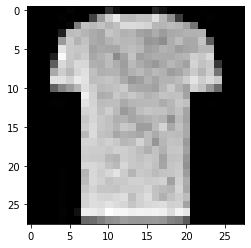

In [55]:
# Eval Performance, Single Instances w Plot
import matplotlib.pyplot as plt #for the imshow func

instance = 125
model.eval()
x, y = test_data[instance][0], test_data[instance][1] #first idx is instance, second determines either data or label, i.e "test_data[instance][data=0 | label=1]"
x = x.to(device) #ensure data is on same device as model! (can get finicky)

with torch.no_grad():
    pred = model(x) #make preds
    predicted, actual = test_data.classes[pred[0].argmax(0)], test_data.classes[y] #map pred & label to actual classes
    print(f'  Pred: {predicted}\nActual: {actual}')

    # Plot Image
    plt.imshow(x.cpu().permute(1, 2, 0), cmap='gray')
        # could also add: `, interpolation="bicubic"` as a param to above for interpolations, kinda cool- https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html


In [9]:
# Manually Eval Test Performance -- On Batches of Test Set w/o Plot
model.eval()

for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        print(f"\npred -- label")
        pred_logit = model(X) #get logits from model
        pred = (pred_logit.argmax(1)) #convert logit to class label pred

        pred = [test_data.classes[i] for i in pred] #map to name
        label = [test_data.classes[i] for i in y]
        for i in range(len(pred)):
            if pred[i] != label[i]: #instances where we mis-clasify examples 
                print(f"{pred[i]} != {label[i]}")



pred -- label
Bag != Ankle boot
Coat != Pullover
Trouser != Coat
Bag != Shirt
Trouser != Sandal
T-shirt/top != Sneaker
Shirt != Sandal
Shirt != Sneaker
Trouser != Dress
Shirt != Pullover
Shirt != Coat
Shirt != Pullover
Trouser != Sandal
Shirt != Ankle boot
Trouser != Coat
Coat != Shirt
Trouser != T-shirt/top
Bag != Ankle boot
Trouser != Dress
Trouser != Dress
Trouser != Dress
T-shirt/top != Bag
Shirt != Sandal
Shirt != Sneaker
Bag != Ankle boot
T-shirt/top != Shirt
Trouser != Dress
Shirt != Sneaker
Coat != Shirt
T-shirt/top != Sneaker
Coat != Pullover
Shirt != Pullover
Coat != Pullover
Shirt != Coat
Shirt != Coat
Shirt != Sandal
Coat != Bag
Trouser != Pullover
Shirt != Pullover
Coat != Bag
Shirt != Bag
Shirt != Sneaker
T-shirt/top != Sneaker
T-shirt/top != Sandal
Trouser != Pullover
Trouser != Dress
Shirt != Ankle boot
T-shirt/top != Sneaker
Trouser != T-shirt/top
Coat != Pullover
Coat != Shirt
Coat != Pullover
Trouser != Dress
Coat != Pullover
T-shirt/top != Sandal
Bag != Ankle boot
